z góry przepraszam za lekki bałagan, ale jesli jest problem to ja tu chętnie pomogę i wszystko szybciutko znajdę


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd


In [ ]:
car_data_transformed = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/car_data_transformed.csv')
recruitment_data_transformed = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/recruitment_data_transformed.csv')
diabetes_data_transformed = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/diabetes_data_transformed.csv')
banknote_authentication_transformed = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/banknote_authentication_transformed.csv')
datasets = [car_data_transformed, recruitment_data_transformed, diabetes_data_transformed, banknote_authentication_transformed]

In [ ]:
datasets[3]['Target'] = datasets[3]['Target'] -1

In [ ]:
model_pipeline = Pipeline([
                         ('model', RandomForestClassifier())])

## REZULTATY NA TOTALNIE DEFAULTOWYCH PARAMETRACH
 kroswalidacja


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import numpy as np

# Tworzymy listę nazw zestawów danych, aby można je było odpowiednio podpisać w wynikach
dataset_names = ["Car Data", "Recruitment Data", "Diabetes Data", "Banknote Authentication"]

# Przechodzimy pętlą po każdym zbiorze danych i wykonujemy walidację krzyżową
for i, data in enumerate(datasets):
    # Tworzymy obiekt Pipeline z modelem RandomForestClassifier
    model_pipeline = Pipeline([('model', RandomForestClassifier())])

    # Przygotowujemy dane - X to dane wejściowe, y to etykieta (Target)
    X = data.drop(columns=['Target'])
    y = data['Target']

    # W przypadku banknotów przesuwamy etykiety o 1
    if dataset_names[i] == "Banknote Authentication":
        y = y - 1

    # Wykorzystanie walidacji krzyżowej do oceny modelu
    scores = cross_val_score(model_pipeline, X, y, cv=10, scoring = 'roc_auc')

    # Wyświetlamy wyniki dla danego zestawu danych
    print(f"\nWyniki walidacji krzyżowej dla {dataset_names[i]}:")
    print("Dokładności dla każdej iteracji:", scores)
    print("Średnia dokładność:", np.mean(scores))
    print("Odchylenie standardowe dokładności:", np.std(scores))



Wyniki walidacji krzyżowej dla Car Data:
Dokładności dla każdej iteracji: [0.94916667 0.94       0.95729167 0.93833333 0.97041667 0.98354167
 0.9425     0.97729167 0.9518396  0.97312939]
Średnia dokładność: 0.9583510662119334
Odchylenie standardowe dokładności: 0.01572861267868827

Wyniki walidacji krzyżowej dla Recruitment Data:
Dokładności dla każdej iteracji: [0.99018798 0.99948358 0.99318323 0.99762446 0.99359636 0.99905936
 0.99393813 0.9979097  0.83246237 0.5388796 ]
Średnia dokładność: 0.9336324768093605
Odchylenie standardowe dokładności: 0.14031609323088629

Wyniki walidacji krzyżowej dla Diabetes Data:
Dokładności dla każdej iteracji: [0.78666667 0.83925926 0.82444444 0.73962963 0.79111111 0.84925926
 0.84333333 0.8962963  0.77961538 0.87769231]
Średnia dokładność: 0.8227307692307694
Odchylenie standardowe dokładności: 0.045718890675013744

Wyniki walidacji krzyżowej dla Banknote Authentication:
Dokładności dla każdej iteracji: [1.         1.         0.99956859 1.         1.

## RANDOM SEARCH

In [ ]:
results = pd.DataFrame()

In [ ]:
#SPRAWDZIC CZY SIE POKRYWAJĄ Z TYMI Z ARTYKUŁU JESZCZE TRZEBA

param_grid = {
    'model__n_estimators': [2**x for x in range(5, 10)],  # Number of trees (from 32 to 512)
    'model__max_depth': [x for x in range(1, 16)],  # Depths from 1 to 15
    'model__min_samples_split': [2**x for x in range(1, 5)],  # Split threshold: 1, 2, 4, 8, 16
    'model__min_samples_leaf': [2**x for x in range(0, 4)],  # Leaf threshold: 1, 2, 4, 8
    'model__max_features': [x / 10 for x in range(1, 11)],  # Max features from 0.1 to 1.0
    'model__bootstrap': [True, False],  # Use bootstrapping or not
    'model__criterion': ['gini', 'entropy','log_loss'],  # Criterion for split quality
}


## Poniżej znajduje sie customowy random search ktory zapisuje wyniki dla każdej kombinacji parametrów


In [ ]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV

class CustomRandomizedSearchCV(RandomizedSearchCV):
    def __init__(self, estimator, param_distributions, n_iter=10, cv=None,
                 refit=True, n_jobs=None, verbose=0, pre_dispatch='2*n_jobs',
                 random_state=None, error_score='raise', return_train_score=False,
                 dataset_name=None, scoring='roc_auc'):
        # Explicitly calling the parent class constructor with named parameters
        super().__init__(estimator=estimator,
                         param_distributions=param_distributions,
                         n_iter=n_iter,
                         cv=cv,
                         refit=refit,
                         n_jobs=n_jobs,
                         verbose=verbose,
                         pre_dispatch=pre_dispatch,
                         random_state=random_state,
                         error_score=error_score,
                         return_train_score=return_train_score,
                         scoring=scoring)

        self.dataset_name = dataset_name
        self.results_df = pd.DataFrame()

    def fit(self, X, y=None, **fit_params):
        super().fit(X, y, **fit_params)

        # Collect results for each iteration
        results = []
        for idx, params in enumerate(self.cv_results_['params']):
            score = self.cv_results_['mean_test_score'][idx]
            params['Combination_ID'] = idx + 1
            params['Score'] = score
            params['Dataset'] = self.dataset_name
            results.append(params)

        # Create a DataFrame from the results
        self.results_df = pd.DataFrame(results)

        return self


### CARS

In [ ]:
# Przykład użycia niestandardowego RandomizedSearchCV
rs = CustomRandomizedSearchCV(
    model_pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    n_iter=300,
    random_state=42,
    dataset_name='car' #UWAGA TU TRZEBA ZMIANIAĆ ŻEBY SIĘ DOBRZE DO RAMKI ZAPISAŁO
)

# Uczenie modelu
rs.fit(datasets[0].drop('Target', axis=1), datasets[0]['Target'])

# Wyświetlenie wyników
print(rs.results_df)
results_df0 = rs.results_df
# Zapisanie wyników do pliku CSV
results_df0.to_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/results_rs_df0_rf.csv', index=False)  # Zapisujemy do pliku CSV
print("Results have been saved to 'results_rs_df0_rf.csv'.")

     model__n_estimators  model__min_samples_split  model__min_samples_leaf  \
0                     32                        16                        2   
1                     32                         2                        8   
2                     64                         4                        1   
3                     32                         4                        2   
4                    512                         8                        8   
..                   ...                       ...                      ...   
295                  128                         8                        8   
296                  128                         4                        1   
297                   64                        16                        8   
298                   64                        16                        8   
299                  256                         4                        4   

     model__max_features  model__max_depth model__c

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### RECRUITMENT

In [ ]:
# Przykład użycia niestandardowego RandomizedSearchCV
rs = CustomRandomizedSearchCV(
    model_pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    n_iter=300,
    random_state=42,
    dataset_name='recruit' #UWAGA TU TRZEBA ZMIANIAĆ ŻEBY SIĘ DOBRZE DO RAMKI ZAPISAŁO
)

# Uczenie modelu
rs.fit(datasets[1].drop('Target', axis=1), datasets[1]['Target'])

# Wyświetlenie wyników
print(rs.results_df)
results_df1 = rs.results_df
# Zapisanie wyników do pliku CSV
results_df1.to_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/results_rs_df1_rf.csv', index=False)  # Zapisujemy do pliku CSV
print("Results have been saved to 'results_rs_df1_rf.csv'.")

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


     model__n_estimators  model__min_samples_split  model__min_samples_leaf  \
0                     32                        16                        2   
1                     32                         2                        8   
2                     64                         4                        1   
3                     32                         4                        2   
4                    512                         8                        8   
..                   ...                       ...                      ...   
295                  128                         8                        8   
296                  128                         4                        1   
297                   64                        16                        8   
298                   64                        16                        8   
299                  256                         4                        4   

     model__max_features  model__max_depth model__c

### DIABETES

In [ ]:
# Przykład użycia niestandardowego RandomizedSearchCV
rs = CustomRandomizedSearchCV(
    model_pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    n_iter=300,
    random_state=42,
    dataset_name='diabetes' #UWAGA TU TRZEBA ZMIANIAĆ ŻEBY SIĘ DOBRZE DO RAMKI ZAPISAŁO
)

# Uczenie modelu
rs.fit(datasets[2].drop('Target', axis=1), datasets[2]['Target'])

# Wyświetlenie wyników
print(rs.results_df)
results_df2 = rs.results_df
# Zapisanie wyników do pliku CSV
results_df2.to_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/results_rs_df2_rf.csv', index=False)  # Zapisujemy do pliku CSV
print("Results have been saved to 'results_rs_df2_rf.csv'.")

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


     model__n_estimators  model__min_samples_split  model__min_samples_leaf  \
0                     32                        16                        2   
1                     32                         2                        8   
2                     64                         4                        1   
3                     32                         4                        2   
4                    512                         8                        8   
..                   ...                       ...                      ...   
295                  128                         8                        8   
296                  128                         4                        1   
297                   64                        16                        8   
298                   64                        16                        8   
299                  256                         4                        4   

     model__max_features  model__max_depth model__c

### BANKNOTE

In [ ]:
# Przykład użycia niestandardowego RandomizedSearchCV
rs = CustomRandomizedSearchCV(
    model_pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    n_iter=300,
    random_state=42,
    dataset_name='banknote' #UWAGA TU TRZEBA ZMIANIAĆ ŻEBY SIĘ DOBRZE DO RAMKI ZAPISAŁO
)

# Uczenie modelu
rs.fit(datasets[3].drop('Target', axis=1), datasets[3]['Target'])

# Wyświetlenie wyników
print(rs.results_df)
results_df3 = rs.results_df
# Zapisanie wyników do pliku CSV
results_df3.to_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/results_rs_df3_rf.csv', index=False)  # Zapisujemy do pliku CSV
print("Results have been saved to 'results_rs_df3_rf.csv'.")

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


     model__n_estimators  model__min_samples_split  model__min_samples_leaf  \
0                     32                        16                        2   
1                     32                         2                        8   
2                     64                         4                        1   
3                     32                         4                        2   
4                    512                         8                        8   
..                   ...                       ...                      ...   
295                  128                         8                        8   
296                  128                         4                        1   
297                   64                        16                        8   
298                   64                        16                        8   
299                  256                         4                        4   

     model__max_features  model__max_depth model__c

In [ ]:
import pandas as pd
#połączenie w jedna dużą ramke

# Krok 1: Wczytanie ramek danych
df0 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/results_rs_df0_rf.csv')
df1 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/results_rs_df1_rf.csv')
df2 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/results_rs_df2_rf.csv')
df3 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/results_rs_df3_rf.csv')

# Krok 2: Skonkatenuj wszystkie ramki w jedną
combined_df = pd.concat([df0, df1, df2, df3], ignore_index=True)

# Krok 3: (Opcjonalnie) Zapisz skonkatonowaną ramkę do pliku CSV
combined_df.to_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/combined_results_rf.csv', index=False)

# Wyświetlenie pierwszych kilku wierszy z połączonej ramki danych
print("Combined DataFrame:")
print(combined_df.head())

Combined DataFrame:
   model__n_estimators  model__min_samples_split  model__min_samples_leaf  \
0                   32                        16                        2   
1                   32                         2                        8   
2                   64                         4                        1   
3                   32                         4                        2   
4                  512                         8                        8   

   model__max_features  model__max_depth model__criterion  model__bootstrap  \
0                  0.8                 5          entropy              True   
1                  0.1                 2             gini              True   
2                  0.7                 9          entropy             False   
3                  0.9                 8             gini              True   
4                  0.5                 2             gini             False   

   Combination_ID     Score Dataset  
0   

##PLOTY DO RANDOM SEARCHA


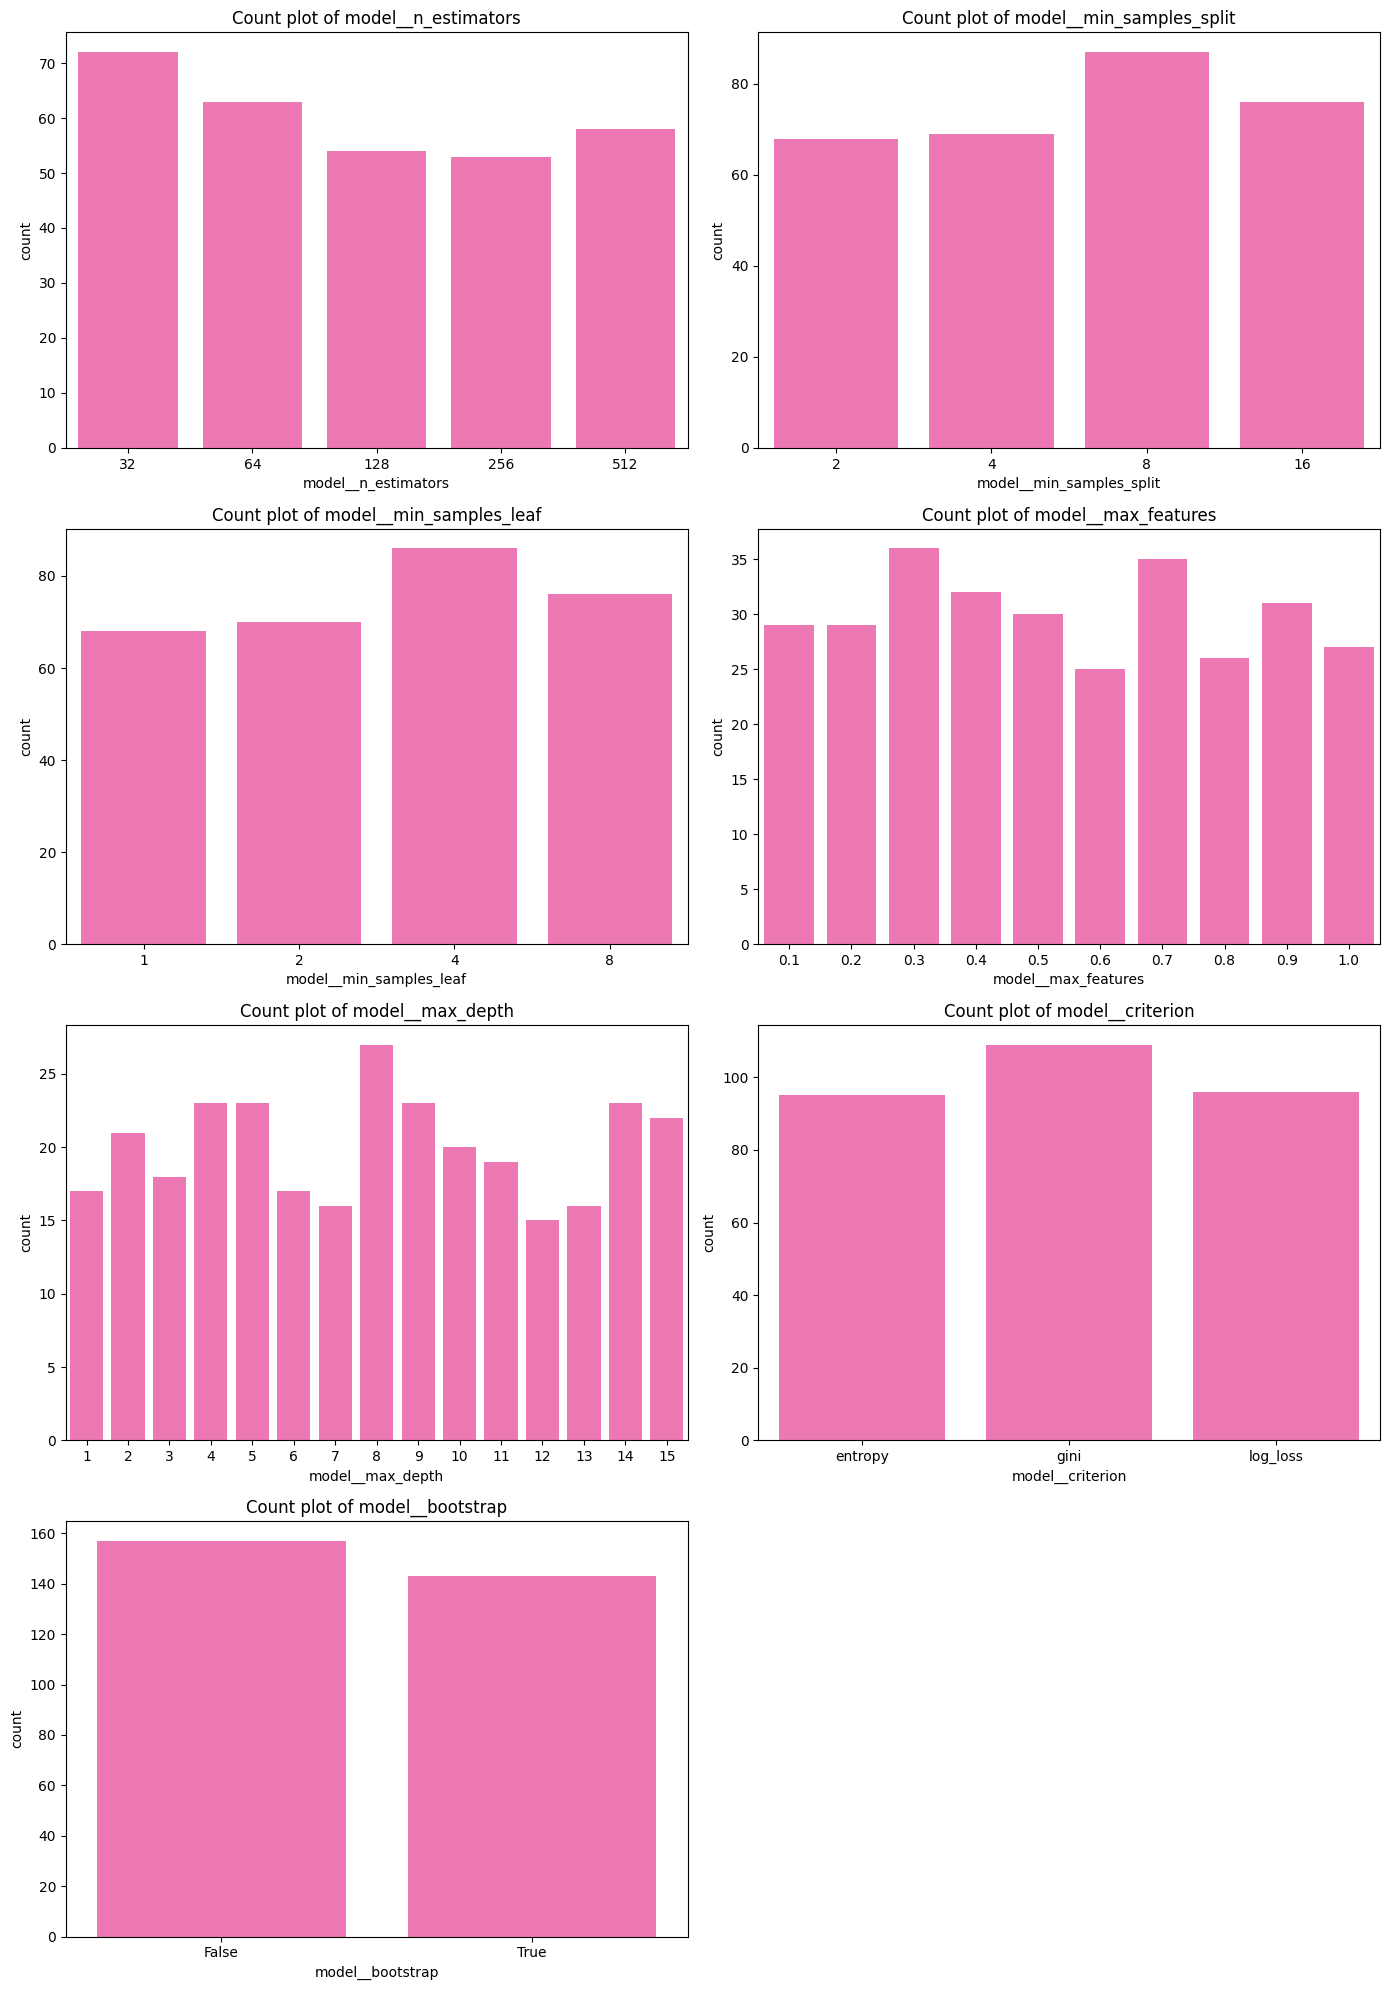

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from CSV
df0 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/results_rs_df0_rf.csv')
df = df0.drop(columns=['Combination_ID', 'Score', 'Dataset'])  # Drop unnecessary columns

# Define a custom pink color
pink_color = "#ff66b3"

# Determine the number of columns for plotting and set up grid dimensions
num_cols = len(df.columns)
num_rows = (num_cols + 1) // 2  # Calculate rows needed for 2 plots per row

# Set up the figure size
plt.figure(figsize=(14, 5 * num_rows))  # Adjust height based on number of rows

# Loop through each column and create a count plot in the appropriate subplot
for idx, col in enumerate(df.columns, 1):
    plt.subplot(num_rows, 2, idx)  # Arrange in 2 columns
    sns.countplot(x=col, data=df, color=pink_color)
    plt.title(f'Count plot of {col}')

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show()


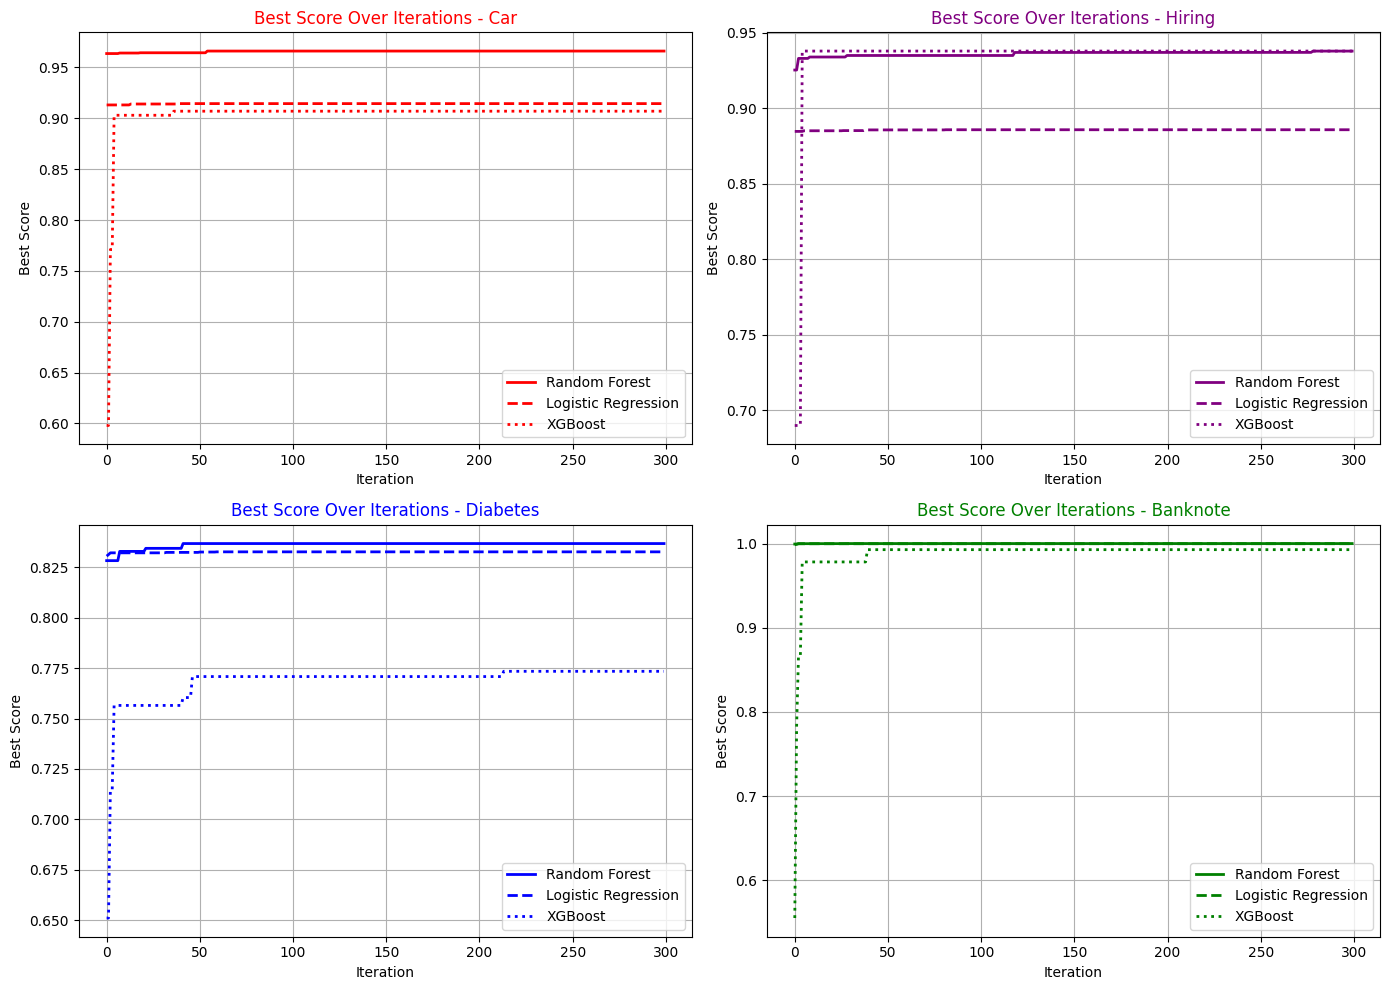

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Load your data
df0 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/results_rs_df0_rf.csv')
df1 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/results_rs_df1_rf.csv')
df2 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/results_rs_df2_rf.csv')
df3 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/results_rs_df3_rf.csv')

df0_lr = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/LogisticRegression/results_rs_car_lr.csv')
df1_lr = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/LogisticRegression/results_rs_hiring_lr.csv')
df2_lr = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/LogisticRegression/results_rs_diabetes_lr.csv')
df3_lr = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/LogisticRegression/results_rs_banknote_lr.csv')

df0_xgb = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/XGBOOST/results_0.csv')
df1_xgb = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/XGBOOST/results_1.csv')
df2_xgb = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/XGBOOST/results_2.csv')
df3_xgb = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/XGBOOST/results_3.csv')

# Compute cumulative best scores for each DataFrame
df0['Best_Score_So_Far'] = df0['Score'].cummax()
df1['Best_Score_So_Far'] = df1['Score'].cummax()
df2['Best_Score_So_Far'] = df2['Score'].cummax()
df3['Best_Score_So_Far'] = df3['Score'].cummax()

df0_lr['Best_Score_So_Far'] = df0_lr['Score'].cummax()
df1_lr['Best_Score_So_Far'] = df1_lr['Score'].cummax()
df2_lr['Best_Score_So_Far'] = df2_lr['Score'].cummax()
df3_lr['Best_Score_So_Far'] = df3_lr['Score'].cummax()

df0_xgb['Best_Score_So_Far'] = df0_xgb['Score'].cummax()
df1_xgb['Best_Score_So_Far'] = df1_xgb['Score'].cummax()
df2_xgb['Best_Score_So_Far'] = df2_xgb['Score'].cummax()
df3_xgb['Best_Score_So_Far'] = df3_xgb['Score'].cummax()

# Set up a 2x2 grid for subplots without shared y-axes
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=False)

# Define data, colors, and titles for each plot
dfs_rf = [df0, df1, df2, df3]
dfs_lr = [df0_lr, df1_lr, df2_lr, df3_lr]
dfs_xgb = [df0_xgb, df1_xgb, df2_xgb, df3_xgb]
base_colors = ["red", "purple", "blue", "green"]
titles = ['Car', 'Hiring', 'Diabetes', 'Banknote']

# Define a list of color maps for varying shades
color_maps = [cm.Reds, cm.Purples, cm.Blues, cm.Greens]

# Plot each cumulative best score in its respective subplot
for i, (df_rf, df_lr, df_xgb, base_color, title) in enumerate(zip(dfs_rf, dfs_lr, dfs_xgb, base_colors, titles)):
    row, col = divmod(i, 2)

    # Generate varying shades of the base color using the colormap
    n_iter_rf = len(df_rf)  # Number of iterations for Random Forest
    n_iter_lr = len(df_lr)  # Number of iterations for Logistic Regression
    n_iter_xgb = len(df_xgb)  # Number of iterations for XGBoost

    # Plot the cumulative best score for Random Forest
    axs[row, col].plot(df_rf.index, df_rf['Best_Score_So_Far'], color=base_color, linewidth=2, label='Random Forest')

    # Plot the cumulative best score for Logistic Regression
    axs[row, col].plot(df_lr.index, df_lr['Best_Score_So_Far'], color=base_color, linestyle='--', linewidth=2, label='Logistic Regression')

    # Plot the cumulative best score for XGBoost
    axs[row, col].plot(df_xgb.index, df_xgb['Best_Score_So_Far'], color=base_color, linestyle=':', linewidth=2, label='XGBoost')

    axs[row, col].set_title(f'Best Score Over Iterations - {title}', color=base_color)
    axs[row, col].set_xlabel('Iteration')
    axs[row, col].set_ylabel('Best Score')
    axs[row, col].grid(True)

    # Add legend
    axs[row, col].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


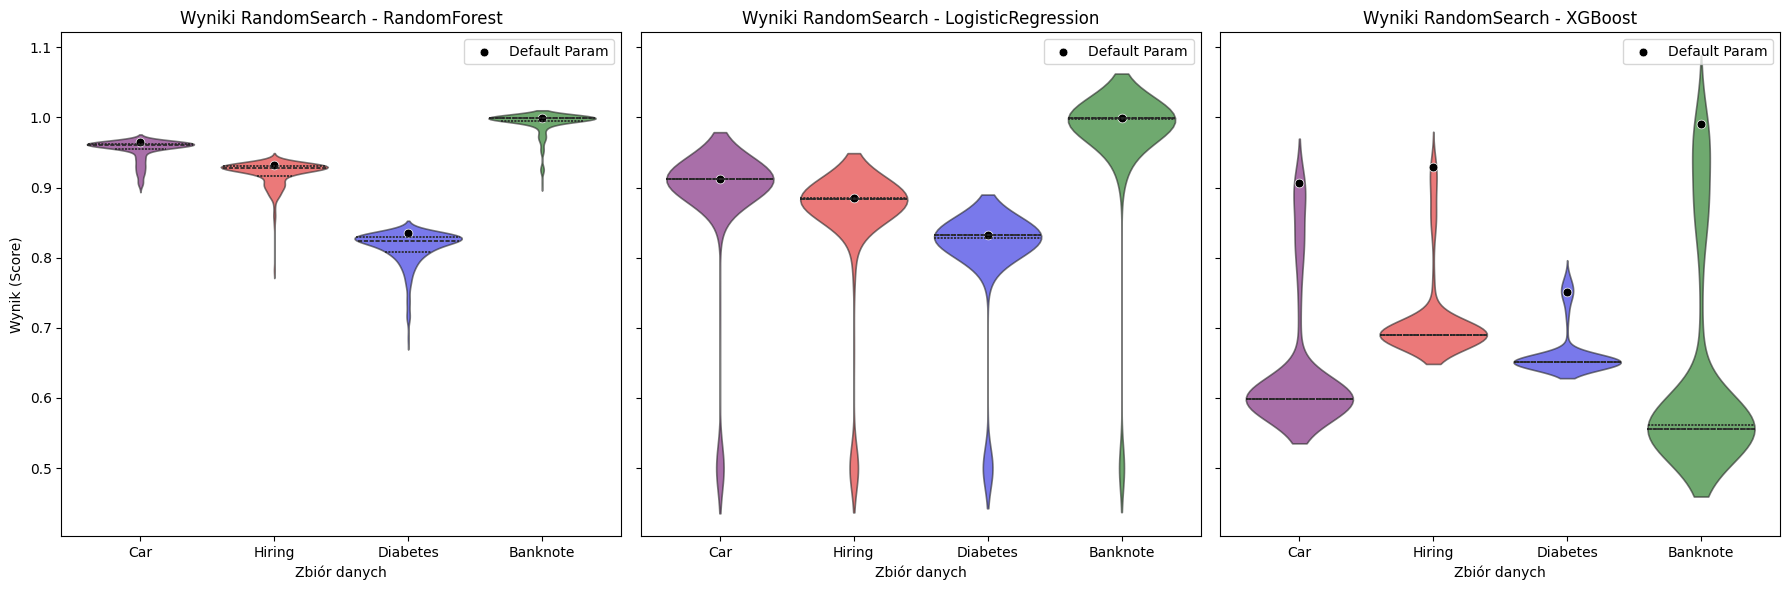

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Zakładamy, że dane są już załadowane do poniższych DataFrame'ów
# dfs_rf - RandomForest dla 4 zestawów danych
# dfs_lr - LogisticRegression dla 4 zestawów danych
# dfs_xgb - XGBoost dla 4 zestawów danych

# Kolory dla violinplotów
colors = ['purple', 'red', 'blue', 'green']
titles = ['Car', 'Hiring', 'Diabetes', 'Banknote']

# Funkcja do przygotowania danych do violin plot dla jednego modelu
def prepare_violin_data(dfs, model_name):
    # Zbieramy wyniki dla każdego zestawu danych do jednego DataFrame
    data = pd.concat([df['Score'] for df in dfs], ignore_index=True)
    datasets = sum([[titles[i]] * len(dfs[i]) for i in range(len(dfs))], [])  # powielanie nazw zbiorów danych
    return pd.DataFrame({'Score': data, 'Dataset': datasets, 'Model': model_name})

# Przygotowanie danych dla każdego modelu
data_rf = prepare_violin_data(dfs_rf, 'RandomForest')
data_lr = prepare_violin_data(dfs_lr, 'LogisticRegression')
data_xgb = prepare_violin_data(dfs_xgb, 'XGBoost')

# Wyniki domyślne dla każdego modelu i zbioru danych
default_scores = {
    'LogisticRegression': [0.9126, 0.8853, 0.8326, 0.9995],
    'RandomForest': [0.9644, 0.9322, 0.8345, 0.9997],
    'XGBoost': [0.9070, 0.9293, 0.7513, 0.9905]
}

# Tworzenie rysunku z trzema subplotami
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Listy danych i nazw dla iteracji
plot_datas = [data_rf, data_lr, data_xgb]
model_names = ['RandomForest', 'LogisticRegression', 'XGBoost']

# Iteracja przez modele i przypisywanie do subplotów
for i, (plot_data, model_name) in enumerate(zip(plot_datas, model_names)):
    sns.violinplot(
        data=plot_data,
        x='Dataset',
        y='Score',
        hue='Dataset',        # Ustawienie 'Dataset' jako hue, aby kolory działały poprawnie
        palette=colors,
        ax=axs[i],
        inner="quartile",
        alpha=0.6,            # Ustawienie przezroczystości
        linewidth=1.2
    )
    axs[i].set_title(f'Wyniki RandomSearch - {model_name}')
    axs[i].set_xlabel('Zbiór danych')
    if i == 0:
        axs[i].set_ylabel('Wynik (Score)')
    else:
        axs[i].set_ylabel('')

    sns.scatterplot(
        x=titles,
        y=default_scores[model_name],
        color='black',
        s=40,
        marker='o',
        edgecolor='white',
        ax=axs[i],
        label='Default Param'
    )

    # Wyłączamy legendę, ponieważ kolory są oczywiste na osi x
    axs[i].legend()

# Dostosowanie układu i wyświetlenie wykresów
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Function to calculate the change in the best score from the 1st to the 10th iteration
def calculate_score_change(df):
    # Ensure the 'Best_Score_So_Far' column is calculated
    if 'Best_Score_So_Far' not in df.columns:
        df['Best_Score_So_Far'] = df['Score'].cummax()  # Calculate cumulative max if not already done

    # Get the score at 1st iteration (index 0) and 10th iteration (index 9)
    score_1st = df['Best_Score_So_Far'].iloc[0]
    score_10th = df['Best_Score_So_Far'].iloc[9] if len(df) >= 10 else score_1st  # Ensure there's at least 10 iterations

    # Calculate the change
    change = score_10th - score_1st
    return change

# List of dataframes for each model (Random Forest, Logistic Regression, XGBoost)
dfs_rf = [df0, df1, df2, df3]
dfs_lr = [df0_lr, df1_lr, df2_lr, df3_lr]
dfs_xgb = [df0_xgb, df1_xgb, df2_xgb, df3_xgb]

# Calculate the change in best score from 1st to 10th iteration for each model
changes_rf = [calculate_score_change(df) for df in dfs_rf]
changes_lr = [calculate_score_change(df) for df in dfs_lr]
changes_xgb = [calculate_score_change(df) for df in dfs_xgb]

# Convert the changes to DataFrame for easy analysis
changes_rf_df = pd.DataFrame({
    'Dataset': ['Car', 'Hiring', 'Diabetes', 'Banknote'],
    'Score Change (Random Forest)': changes_rf
})
changes_lr_df = pd.DataFrame({
    'Dataset': ['Car', 'Hiring', 'Diabetes', 'Banknote'],
    'Score Change (Logistic Regression)': changes_lr
})
changes_xgb_df = pd.DataFrame({
    'Dataset': ['Car', 'Hiring', 'Diabetes', 'Banknote'],
    'Score Change (XGBoost)': changes_xgb
})

# Combine all changes into a single DataFrame
changes_all_df = pd.merge(changes_rf_df, changes_lr_df, on='Dataset')
changes_all_df = pd.merge(changes_all_df, changes_xgb_df, on='Dataset')

# Calculate the mean and standard deviation of the score changes for each model
mean_change_rf = changes_rf_df['Score Change (Random Forest)'].mean()
std_change_rf = changes_rf_df['Score Change (Random Forest)'].std()

mean_change_lr = changes_lr_df['Score Change (Logistic Regression)'].mean()
std_change_lr = changes_lr_df['Score Change (Logistic Regression)'].std()

mean_change_xgb = changes_xgb_df['Score Change (XGBoost)'].mean()
std_change_xgb = changes_xgb_df['Score Change (XGBoost)'].std()

# Display the results
print(f"Random Forest - Mean change: {mean_change_rf}, Standard deviation: {std_change_rf}")
print(f"Logistic Regression - Mean change: {mean_change_lr}, Standard deviation: {std_change_lr}")
print(f"XGBoost - Mean change: {mean_change_xgb}, Standard deviation: {std_change_xgb}")

# Display the combined DataFrame with changes for each model
print("\nScore changes for each dataset and model:")
print(changes_all_df)



Random Forest - Mean change: 0.00355890930215777, Standard deviation: 0.003882176841697697
Logistic Regression - Mean change: 0.0008202163082749181, Standard deviation: 0.000743009134191697
XGBoost - Mean change: 0.2703055102522535, Standard deviation: 0.13179618261103812

Score changes for each dataset and model:
    Dataset  Score Change (Random Forest)  Score Change (Logistic Regression)  \
0       Car                      0.000513                            0.000000   
1    Hiring                      0.008621                            0.000418   
2  Diabetes                      0.004586                            0.001624   
3  Banknote                      0.000516                            0.001240   

   Score Change (XGBoost)  
0                0.305009  
1                0.248000  
2                0.105469  
3                0.422745  


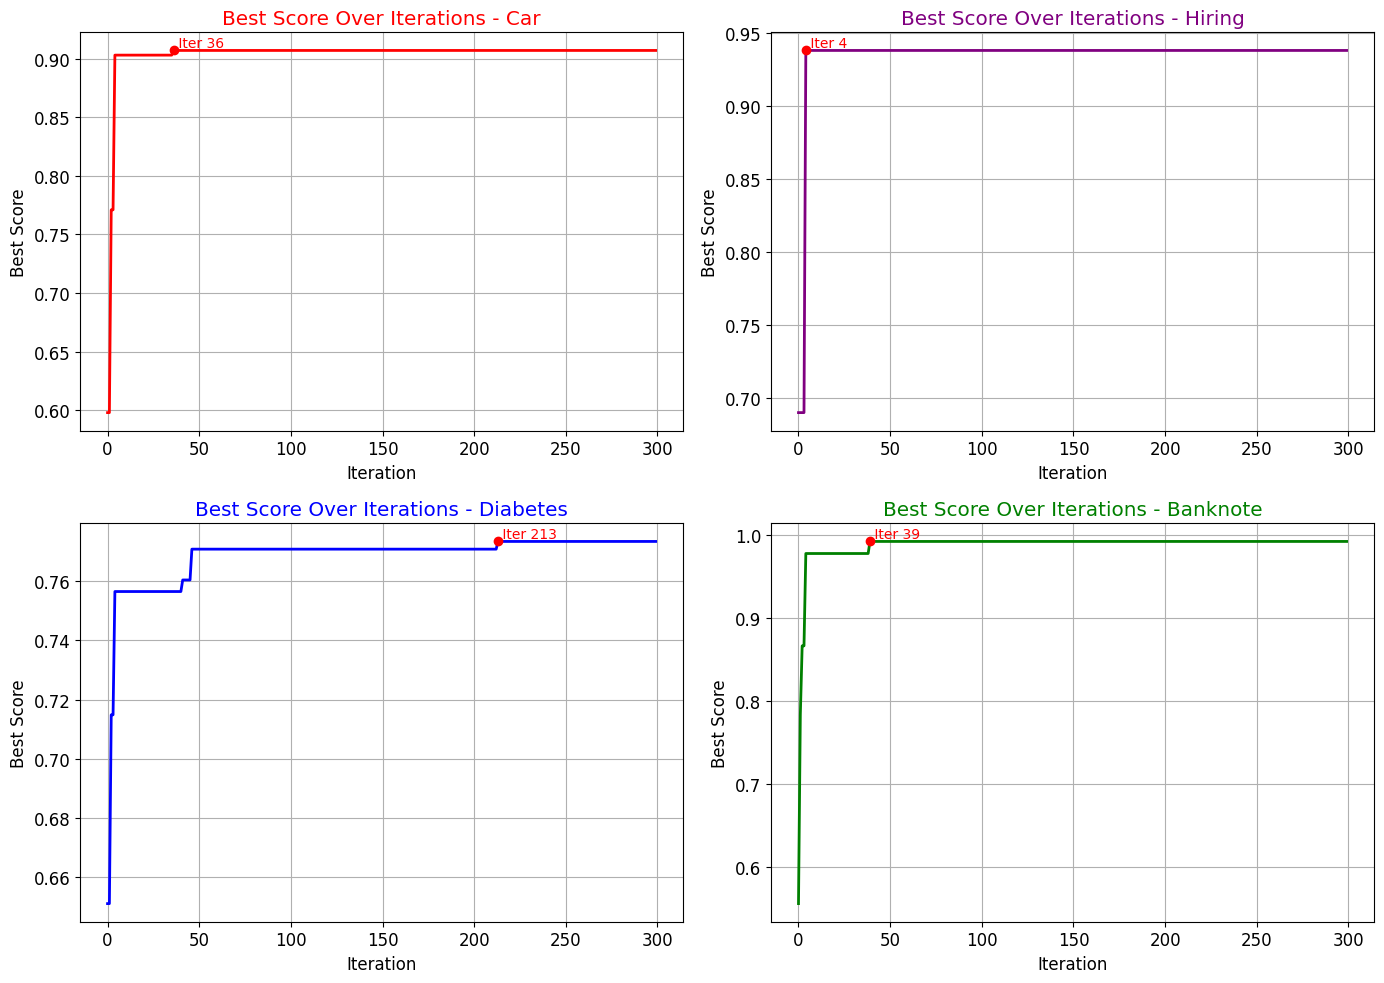

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df0 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/XGBOOST/results_0.csv')
df1 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/XGBOOST/results_1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/XGBOOST/results_2.csv')
df3 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/XGBOOST/results_3.csv')

# Compute cumulative best scores for each DataFrame
df0['Best_Score_So_Far'] = df0['Score'].cummax()
df1['Best_Score_So_Far'] = df1['Score'].cummax()
df2['Best_Score_So_Far'] = df2['Score'].cummax()
df3['Best_Score_So_Far'] = df3['Score'].cummax()

# Set up a 2x2 grid for subplots without shared y-axes
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=False)

# Define data, colors, and titles for each plot
dfs = [df0, df1, df2, df3]
colors = ["red", "purple", "blue", "green"]
titles = ['Car', 'Hiring', 'Diabetes', 'Banknote']

# Plot each cumulative best score in its respective subplot
for i, (df, color, title) in enumerate(zip(dfs, colors, titles)):
    row, col = divmod(i, 2)

    # Find the iteration where the best score occurred
    best_iteration = df['Best_Score_So_Far'].idxmax()
    best_score = df['Best_Score_So_Far'].max()

    # Plot the cumulative best score
    axs[row, col].plot(df.index, df['Best_Score_So_Far'], color=color, linewidth=2)
    axs[row, col].set_title(f'Best Score Over Iterations - {title}', color=color)
    axs[row, col].set_xlabel('Iteration')
    axs[row, col].set_ylabel('Best Score')
    axs[row, col].grid(True)

    # Mark and label the iteration with the best score
    axs[row, col].plot(best_iteration, best_score, 'ro')  # Red dot
    axs[row, col].text(best_iteration, best_score, f' Iter {best_iteration}',
                       color='red', ha='left', va='bottom', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

najlepsze rezultaty dla poszczególnych datasetów:

In [ ]:
combined_df = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/combined_results_rf.csv')

In [ ]:
# Zakładamy, że kolumna ze scores to 'Score', a kolumna z nazwą zbioru to 'Dataset'
best_results = combined_df.loc[combined_df.groupby('Dataset')['Score'].idxmax()]

# Krok 3: Wyświetl najlepsze wyniki
print("Best results for each dataset:")
print(best_results)

Best results for each dataset:
     model__n_estimators  model__min_samples_split  model__min_samples_leaf  \
927                   64                         4                        1   
54                    64                         4                        4   
641                  512                        16                        2   
578                   32                         4                        2   

     model__max_features  model__max_depth model__criterion  model__bootstrap  \
927                  0.2                12          entropy             False   
54                   0.8                11         log_loss              True   
641                  0.5                 7          entropy              True   
578                  0.7                 8         log_loss             False   

     Combination_ID     Score   Dataset  
927              28  0.999955  banknote  
54               55  0.966123       car  
641              42  0.836824  diabetes  

wylicznie defaultu: średnia


In [ ]:
# Krok 2: Oblicz średni wynik dla każdej kombinacji parametrów
mean_scores = combined_df.groupby('Combination_ID')['Score'].mean().reset_index()

# Krok 3: Zidentyfikuj Combination_ID z największym średnim wynikiem
best_combination_id = mean_scores.loc[mean_scores['Score'].idxmax()]

# Krok 4: Wyciągnij parametry dla tego Combination_ID
best_combination_details = combined_df[combined_df['Combination_ID'] == best_combination_id['Combination_ID']]

# Krok 5: Wyświetl wynik
print("Combination_ID with the highest average score:")
print(best_combination_id)

print("\nParameters for this Combination_ID:")
print(best_combination_details)

Combination_ID with the highest average score:
Combination_ID    170.000000
Score               0.932698
Name: 169, dtype: float64

Parameters for this Combination_ID:
      model__n_estimators  model__min_samples_split  model__min_samples_leaf  \
169                   256                         8                        4   
469                   256                         8                        4   
769                   256                         8                        4   
1069                  256                         8                        4   

      model__max_features  model__max_depth model__criterion  \
169                   0.2                 8         log_loss   
469                   0.2                 8         log_loss   
769                   0.2                 8         log_loss   
1069                  0.2                 8         log_loss   

      model__bootstrap  Combination_ID     Score   Dataset  
169              False             170  0.964445 

### dodane odchylenie

In [ ]:
combined_df = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Dane/combined_results_rf.csv')

# Krok 2: Oblicz średni wynik oraz odchylenie standardowe dla każdej kombinacji parametrów
mean_scores = combined_df.groupby('Combination_ID')['Score'].agg(['mean', 'std']).reset_index()

# Krok 3: Zidentyfikuj Combination_ID z największym średnim wynikiem
best_combination_id = mean_scores.loc[mean_scores['mean'].idxmax()]

# Krok 4: Wyciągnij parametry dla tego Combination_ID
best_combination_details = combined_df[combined_df['Combination_ID'] == best_combination_id['Combination_ID']]

# Krok 5: Wyświetl wynik
print("Combination_ID with the highest average score:")
print(best_combination_id)

print("\nParameters for this Combination_ID:")
print(best_combination_details)

Combination_ID with the highest average score:
Combination_ID    170.000000
mean                0.932698
std                 0.071043
Name: 169, dtype: float64

Parameters for this Combination_ID:
      model__n_estimators  model__min_samples_split  model__min_samples_leaf  \
169                   256                         8                        4   
469                   256                         8                        4   
769                   256                         8                        4   
1069                  256                         8                        4   

      model__max_features  model__max_depth model__criterion  \
169                   0.2                 8         log_loss   
469                   0.2                 8         log_loss   
769                   0.2                 8         log_loss   
1069                  0.2                 8         log_loss   

      model__bootstrap  Combination_ID     Score   Dataset  
169              Fal

znalezione defaultowe parametry: ## do zmiany pewnie


n_estimators = 256

min_samples_split = 8

min_samples_leaf = 4

max_features = 0.2

max_depth = 8

criterion = log_loss

bootstrap = False



## BAYES

In [ ]:
#! pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.5 MB/s eta 0:00:00


In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [ ]:
results_bayes = pd.DataFrame()

In [ ]:
param_grid_bayes = {
    'model__n_estimators': Integer(32, 512),                        # Liczba drzew (od 32 do 512)
    'model__max_depth': Integer(1, 15),                             # Maksymalna głębokość (od 1 do 15)
    'model__min_samples_split': Integer(2, 16),                     # Minimalna liczba próbek do podziału (od 2 do 16)
    'model__min_samples_leaf': Integer(1, 8),                       # Minimalna liczba próbek na liść (od 1 do 8)
    'model__max_features': Real(0.1, 1.0),                          # Maksymalna liczba cech (od 0.1 do 1.0)
    'model__bootstrap': Categorical([True, False]),                 # Czy używać bootstrappingu
    'model__criterion': Categorical(['gini', 'entropy', 'log_loss']) # Kryterium podziału
}

In [ ]:
def performBayes(X, y, dataset_name, n):
    results = pd.DataFrame()
    for i in range(n):
        print('Iteration', i+1, 'in progress...,')
        #change starting point for every iteration
        bs = BayesSearchCV(model_pipeline,
                   param_grid_bayes,
                   cv = 3,
                   n_iter=30,
                   n_jobs=-1,
                   random_state=42+i,
                   scoring='roc_auc'
                   )
        bs.fit(X,y)
        res = pd.DataFrame(bs.best_params_, index=[0])
        res['Score'] = bs.best_score_
        results = pd.concat([results, res])

    results.to_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/RANDOMFOREST/results_bayes_'+str(dataset_name) + '.csv')
    print('Done!')
    return results

### CARS

In [ ]:
b0 = performBayes(datasets[0].drop('Target', axis=1), datasets[0]['Target'], 0, 50)

Iteration 1 in progress...,
Iteration 2 in progress...,
Iteration 3 in progress...,
Iteration 4 in progress...,
Iteration 5 in progress...,
Iteration 6 in progress...,
Iteration 7 in progress...,
Iteration 8 in progress...,
Iteration 9 in progress...,
Iteration 10 in progress...,
Iteration 11 in progress...,
Iteration 12 in progress...,
Iteration 13 in progress...,
Iteration 14 in progress...,
Iteration 15 in progress...,
Iteration 16 in progress...,
Iteration 17 in progress...,
Iteration 18 in progress...,
Iteration 19 in progress...,
Iteration 20 in progress...,
Iteration 21 in progress...,
Iteration 22 in progress...,
Iteration 23 in progress...,
Iteration 24 in progress...,
Iteration 25 in progress...,
Iteration 26 in progress...,
Iteration 27 in progress...,
Iteration 28 in progress...,
Iteration 29 in progress...,
Iteration 30 in progress...,


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, 'entropy', 10, 1.0, 8, 16, 512] before, using random point [False, 'entropy', 2, 0.7634139202341585, 2, 11, 274]
  warnings.warn(


Iteration 31 in progress...,
Iteration 32 in progress...,
Iteration 33 in progress...,
Iteration 34 in progress...,
Iteration 35 in progress...,
Iteration 36 in progress...,
Iteration 37 in progress...,
Iteration 38 in progress...,
Iteration 39 in progress...,
Iteration 40 in progress...,
Iteration 41 in progress...,
Iteration 42 in progress...,
Iteration 43 in progress...,
Iteration 44 in progress...,
Iteration 45 in progress...,
Iteration 46 in progress...,
Iteration 47 in progress...,
Iteration 48 in progress...,
Iteration 49 in progress...,
Iteration 50 in progress...,
Done!


In [ ]:
b1 = performBayes(datasets[1].drop('Target', axis=1), datasets[1]['Target'], 1, 50)

Iteration 1 in progress...,
Iteration 2 in progress...,
Iteration 3 in progress...,
Iteration 4 in progress...,
Iteration 5 in progress...,
Iteration 6 in progress...,
Iteration 7 in progress...,
Iteration 8 in progress...,
Iteration 9 in progress...,


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Iteration 10 in progress...,
Iteration 11 in progress...,
Iteration 12 in progress...,
Iteration 13 in progress...,
Iteration 14 in progress...,
Iteration 15 in progress...,
Iteration 16 in progress...,
Iteration 17 in progress...,
Iteration 18 in progress...,
Iteration 19 in progress...,
Iteration 20 in progress...,
Iteration 21 in progress...,
Iteration 22 in progress...,
Iteration 23 in progress...,
Iteration 24 in progress...,
Iteration 25 in progress...,
Iteration 26 in progress...,
Iteration 27 in progress...,
Iteration 28 in progress...,
Iteration 29 in progress...,
Iteration 30 in progress...,
Iteration 31 in progress...,
Iteration 32 in progress...,
Iteration 33 in progress...,
Iteration 34 in progress...,
Iteration 35 in progress...,
Iteration 36 in progress...,
Iteration 37 in progress...,
Iteration 38 in progress...,
Iteration 39 in progress...,
Iteration 40 in progress...,
Iteration 41 in progress...,
Iteration 42 in progress...,
Iteration 43 in progress...,
Iteration 44 i

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Done!


In [ ]:
b2 = performBayes(datasets[2].drop('Target', axis=1), datasets[2]['Target'], 2, 50)

Iteration 1 in progress...,
Iteration 2 in progress...,


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Iteration 3 in progress...,
Iteration 4 in progress...,
Iteration 5 in progress...,
Iteration 6 in progress...,
Iteration 7 in progress...,
Iteration 8 in progress...,
Iteration 9 in progress...,
Iteration 10 in progress...,
Iteration 11 in progress...,
Iteration 12 in progress...,
Iteration 13 in progress...,
Iteration 14 in progress...,
Iteration 15 in progress...,
Iteration 16 in progress...,
Iteration 17 in progress...,
Iteration 18 in progress...,
Iteration 19 in progress...,
Iteration 20 in progress...,
Iteration 21 in progress...,
Iteration 22 in progress...,
Iteration 23 in progress...,
Iteration 24 in progress...,
Iteration 25 in progress...,
Iteration 26 in progress...,
Iteration 27 in progress...,
Iteration 28 in progress...,
Iteration 29 in progress...,
Iteration 30 in progress...,
Iteration 31 in progress...,
Iteration 32 in progress...,
Iteration 33 in progress...,
Iteration 34 in progress...,
Iteration 35 in progress...,
Iteration 36 in progress...,
Iteration 37 in progr

In [ ]:
b3 = performBayes(datasets[3].drop('Target', axis=1), datasets[3]['Target'], 3, 50)

Iteration 1 in progress...,
Iteration 2 in progress...,
Iteration 3 in progress...,
Iteration 4 in progress...,
Iteration 5 in progress...,
Iteration 6 in progress...,
Iteration 7 in progress...,
Iteration 8 in progress...,
Iteration 9 in progress...,
Iteration 10 in progress...,
Iteration 11 in progress...,
Iteration 12 in progress...,
Iteration 13 in progress...,
Iteration 14 in progress...,
Iteration 15 in progress...,
Iteration 16 in progress...,
Iteration 17 in progress...,
Iteration 18 in progress...,
Iteration 19 in progress...,
Iteration 20 in progress...,
Iteration 21 in progress...,
Iteration 22 in progress...,
Iteration 23 in progress...,
Iteration 24 in progress...,
Iteration 25 in progress...,
Iteration 26 in progress...,
Iteration 27 in progress...,
Iteration 28 in progress...,
Iteration 29 in progress...,
Iteration 30 in progress...,
Iteration 31 in progress...,
Iteration 32 in progress...,
Iteration 33 in progress...,
Iteration 34 in progress...,
Iteration 35 in progres

bayes rezultaty

In [ ]:
import pandas as pd
#połączenie w jedna dużą ramke

# Krok 1: Wczytanie ramek danych
df0 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/RANDOMFOREST/results_bayes_0.csv')
df1 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/RANDOMFOREST/results_bayes_1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/RANDOMFOREST/results_bayes_2.csv')
df3 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/RANDOMFOREST/results_bayes_3.csv')

# Krok 2: Skonkatenuj wszystkie ramki w jedną
combined_df = pd.concat([df0, df1, df2, df3], ignore_index=True)

# Krok 3: (Opcjonalnie) Zapisz skonkatonowaną ramkę do pliku CSV
combined_df.to_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/RANDOMFOREST/combined_results_rf_bayes.csv', index=False)

# Wyświetlenie pierwszych kilku wierszy z połączonej ramki danych
print("Combined DataFrame:")
print(combined_df.head())

Combined DataFrame:
   Unnamed: 0  model__bootstrap model__criterion  model__max_depth  \
0           0             False         log_loss                 5   
1           0             False         log_loss                11   
2           0             False          entropy                 5   
3           0             False         log_loss                13   
4           0             False          entropy                14   

   model__max_features  model__min_samples_leaf  model__min_samples_split  \
0             0.956102                        7                         3   
1             0.851023                        5                         8   
2             0.786909                        5                        16   
3             0.713536                        4                         9   
4             0.923458                        7                         5   

   model__n_estimators     Score  
0                   98  0.965112  
1                   50  0.

In [ ]:
combined_df = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/RANDOMFOREST/combined_results_rf_bayes.csv')

In [ ]:
# Wyjmowanie najlepszego rezultatu na podstawie kolumny 'Dcore'
best_result_0 = df0.loc[df0['Score'].idxmax()]
best_result_1 = df1.loc[df1['Score'].idxmax()]
best_result_2 = df2.loc[df2['Score'].idxmax()]
best_result_3 = df3.loc[df3['Score'].idxmax()]

# Tworzenie nowej ramki danych z najlepszymi rezultatami
best_results = pd.DataFrame([best_result_0, best_result_1, best_result_2, best_result_3])

# Wyświetlenie najlepszych rezultatów
print(best_results)


    Unnamed: 0  model__bootstrap model__criterion  model__max_depth  \
47           0              True          entropy                 6   
8            0             False         log_loss                13   
37           0              True         log_loss                 4   
6            0             False         log_loss                15   

    model__max_features  model__min_samples_leaf  model__min_samples_split  \
47             0.471698                        1                         2   
8              0.546895                        1                         9   
37             0.349241                        3                         6   
6              0.328103                        1                         6   

    model__n_estimators     Score  
47                  150  0.965786  
8                    32  0.940564  
37                  129  0.841333  
6                    39  0.999955  


In [ ]:
import pandas as pd
#połączenie w jedna dużą ramke

# Krok 1: Wczytanie ramek danych
df0 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/RANDOMFOREST/results_bayes_0.csv')
df1 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/RANDOMFOREST/results_bayes_1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/RANDOMFOREST/results_bayes_2.csv')
df3 = pd.read_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/RANDOMFOREST/results_bayes_3.csv')

# Krok 2: Skonkatenuj wszystkie ramki w jedną
df0.rename(columns={'Unnamed: 0': 'dataset'}, inplace=True)
df0['dataset'] = 0
df1.rename(columns={'Unnamed: 0': 'dataset'}, inplace=True)
df1['dataset'] = 1
df2.rename(columns={'Unnamed: 0': 'dataset'}, inplace=True)
df2['dataset'] = 2
df3.rename(columns={'Unnamed: 0': 'dataset'}, inplace=True)
df3['dataset'] = 3

combined_df = pd.concat([df0, df1, df2, df3], ignore_index=True)

# Krok 3: (Opcjonalnie) Zapisz skonkatonowaną ramkę do pliku CSV
combined_df.to_csv('/content/drive/MyDrive/AutoML-Projekt1/Results/RANDOMFOREST/combined_results_rf_bayes.csv', index=False)

# Wyświetlenie pierwszych kilku wierszy z połączonej ramki danych
print("Combined DataFrame:")
print(combined_df.head())

Combined DataFrame:
   dataset  model__bootstrap model__criterion  model__max_depth  \
0        0             False         log_loss                 5   
1        0             False         log_loss                11   
2        0             False          entropy                 5   
3        0             False         log_loss                13   
4        0             False          entropy                14   

   model__max_features  model__min_samples_leaf  model__min_samples_split  \
0             0.956102                        7                         3   
1             0.851023                        5                         8   
2             0.786909                        5                        16   
3             0.713536                        4                         9   
4             0.923458                        7                         5   

   model__n_estimators     Score  
0                   98  0.965112  
1                   50  0.964171  
2        

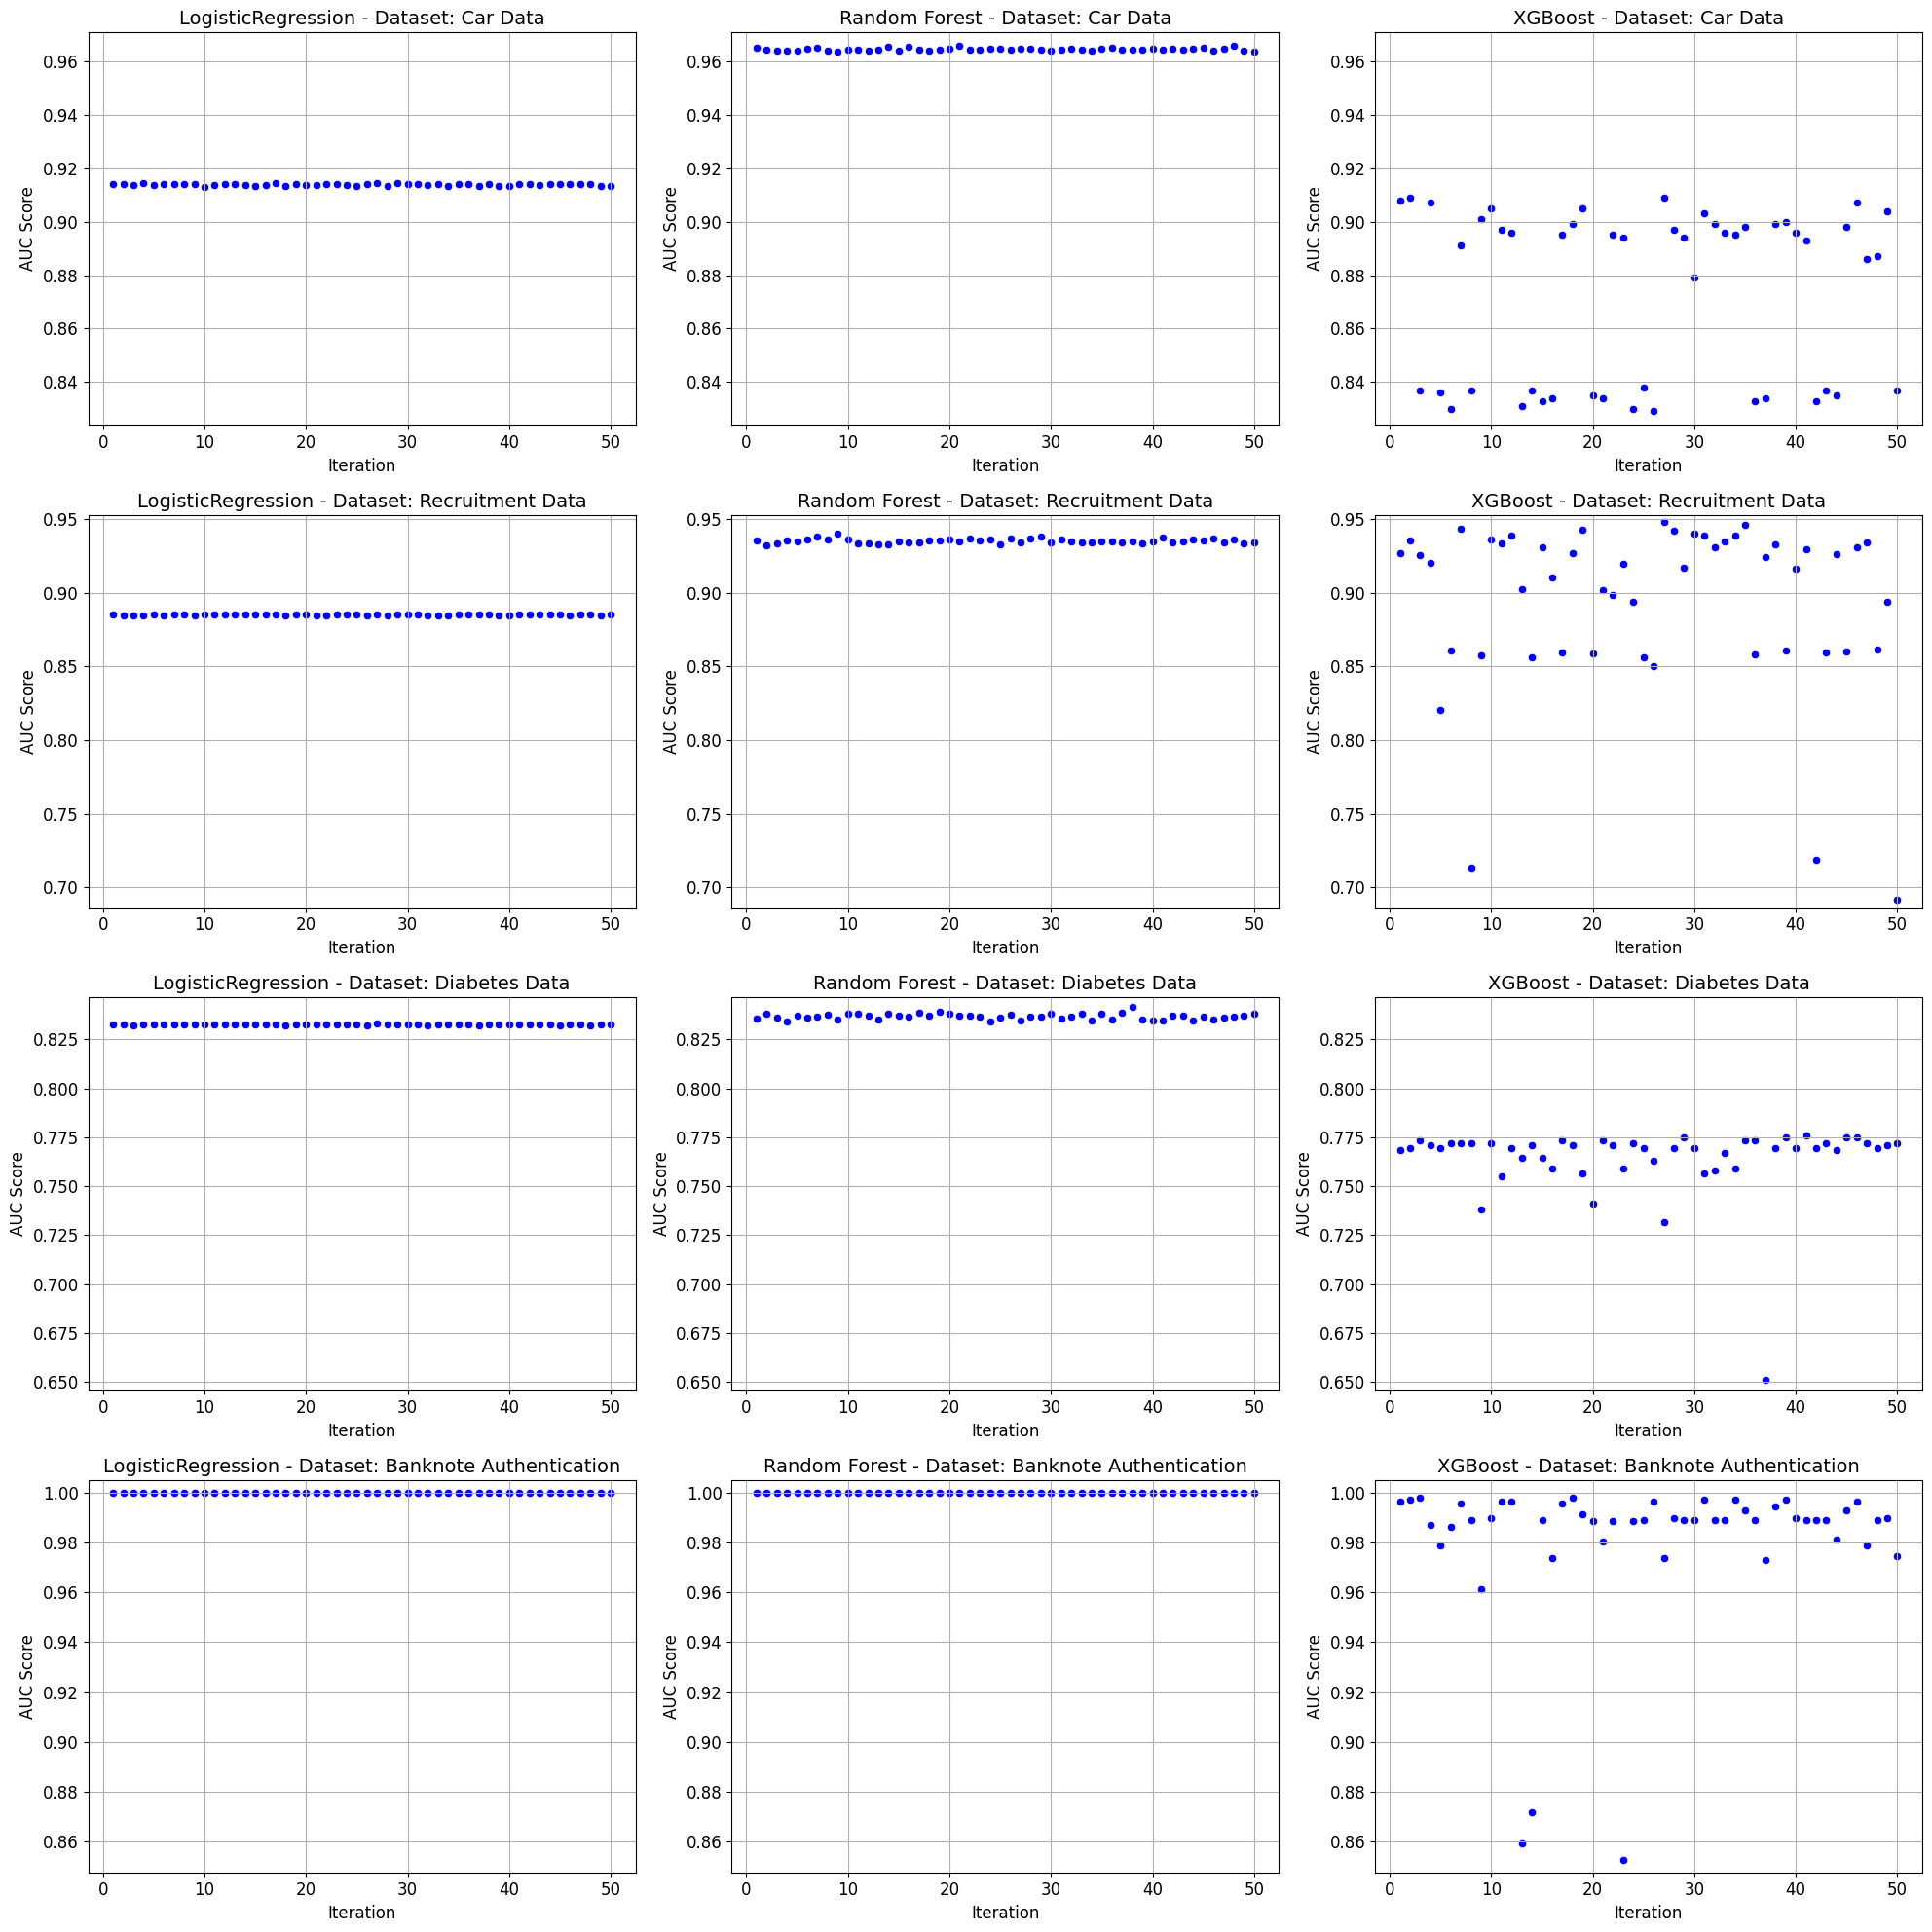

In [ ]:
df = pd.read_csv(f'/content/drive/MyDrive/AutoML-Projekt1/Results/RANDOMFOREST/results_bayes_{i}.csv')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Przygotowujemy listę DataFrame'ów dla każdego modelu
model_names = ["LogisticRegression", "Random Forest", "XGBoost"]

# Ustawienia dla większych podpisów
plt.rcParams.update({'font.size': 12})

# Tworzymy subploty: 4 wiersze (dla zbiorów danych) i 3 kolumny (dla modeli)
fig, axes = plt.subplots(4, 3, figsize=(20, 20))  # 4 wiersze, 3 kolumny

# Iteracja przez każdy zbiór danych (4 wiersze)
for i in range(4):
    # Wczytujemy dane dla `results_bayes` z plików CSV
    df_data = [
        pd.read_csv(f'/content/drive/MyDrive/AutoML-Projekt1/Results/{model_name}/results_bayes_{i}.csv')
        for model_name in ["LogisticRegression", "RANDOMFOREST", "XGBOOST"]
    ]

    # Znajdź minimalny i maksymalny Score dla każdego wiersza, aby ustawić wspólną skalę osi Y w danym wierszu
    min_score = min(df['Score'].min() for df in df_data)
    max_score = max(df['Score'].max() for df in df_data)

    # Iteracja przez każdy model (3 kolumny)
    for j in range(3):
        # Wykres punktowy AUC Score z linią pomocniczą dla iteracji
        sns.scatterplot(
            x=np.linspace(1, 50, 50), y=df_data[j]['Score'], marker='o', color='blue', ax=axes[i, j]
        )

        # Ustawiamy tytuł, opisy osi oraz zakres osi Y
        axes[i, j].set_title(f"{model_names[j]} - Dataset: {dataset_names[i]}", fontsize=14)
        axes[i, j].set_xlabel("Iteration", fontsize=12)
        axes[i, j].set_ylabel("AUC Score", fontsize=12)

        # Ustawienie tej samej skali Y dla wszystkich wykresów w danym wierszu
        axes[i, j].set_ylim(min_score - 0.005, max_score + 0.005)

        # Włączamy siatkę dla lepszej widoczności
        axes[i, j].grid(True)

# Dostosowujemy odstępy między wykresami
plt.tight_layout()

# Wyświetlamy i zapisujemy wykresy jako jeden plik PNG
plt.show()
fig.savefig('/content/drive/MyDrive/AutoML-Projekt1/Results/bayes_search_all_models_all_datasets.png')



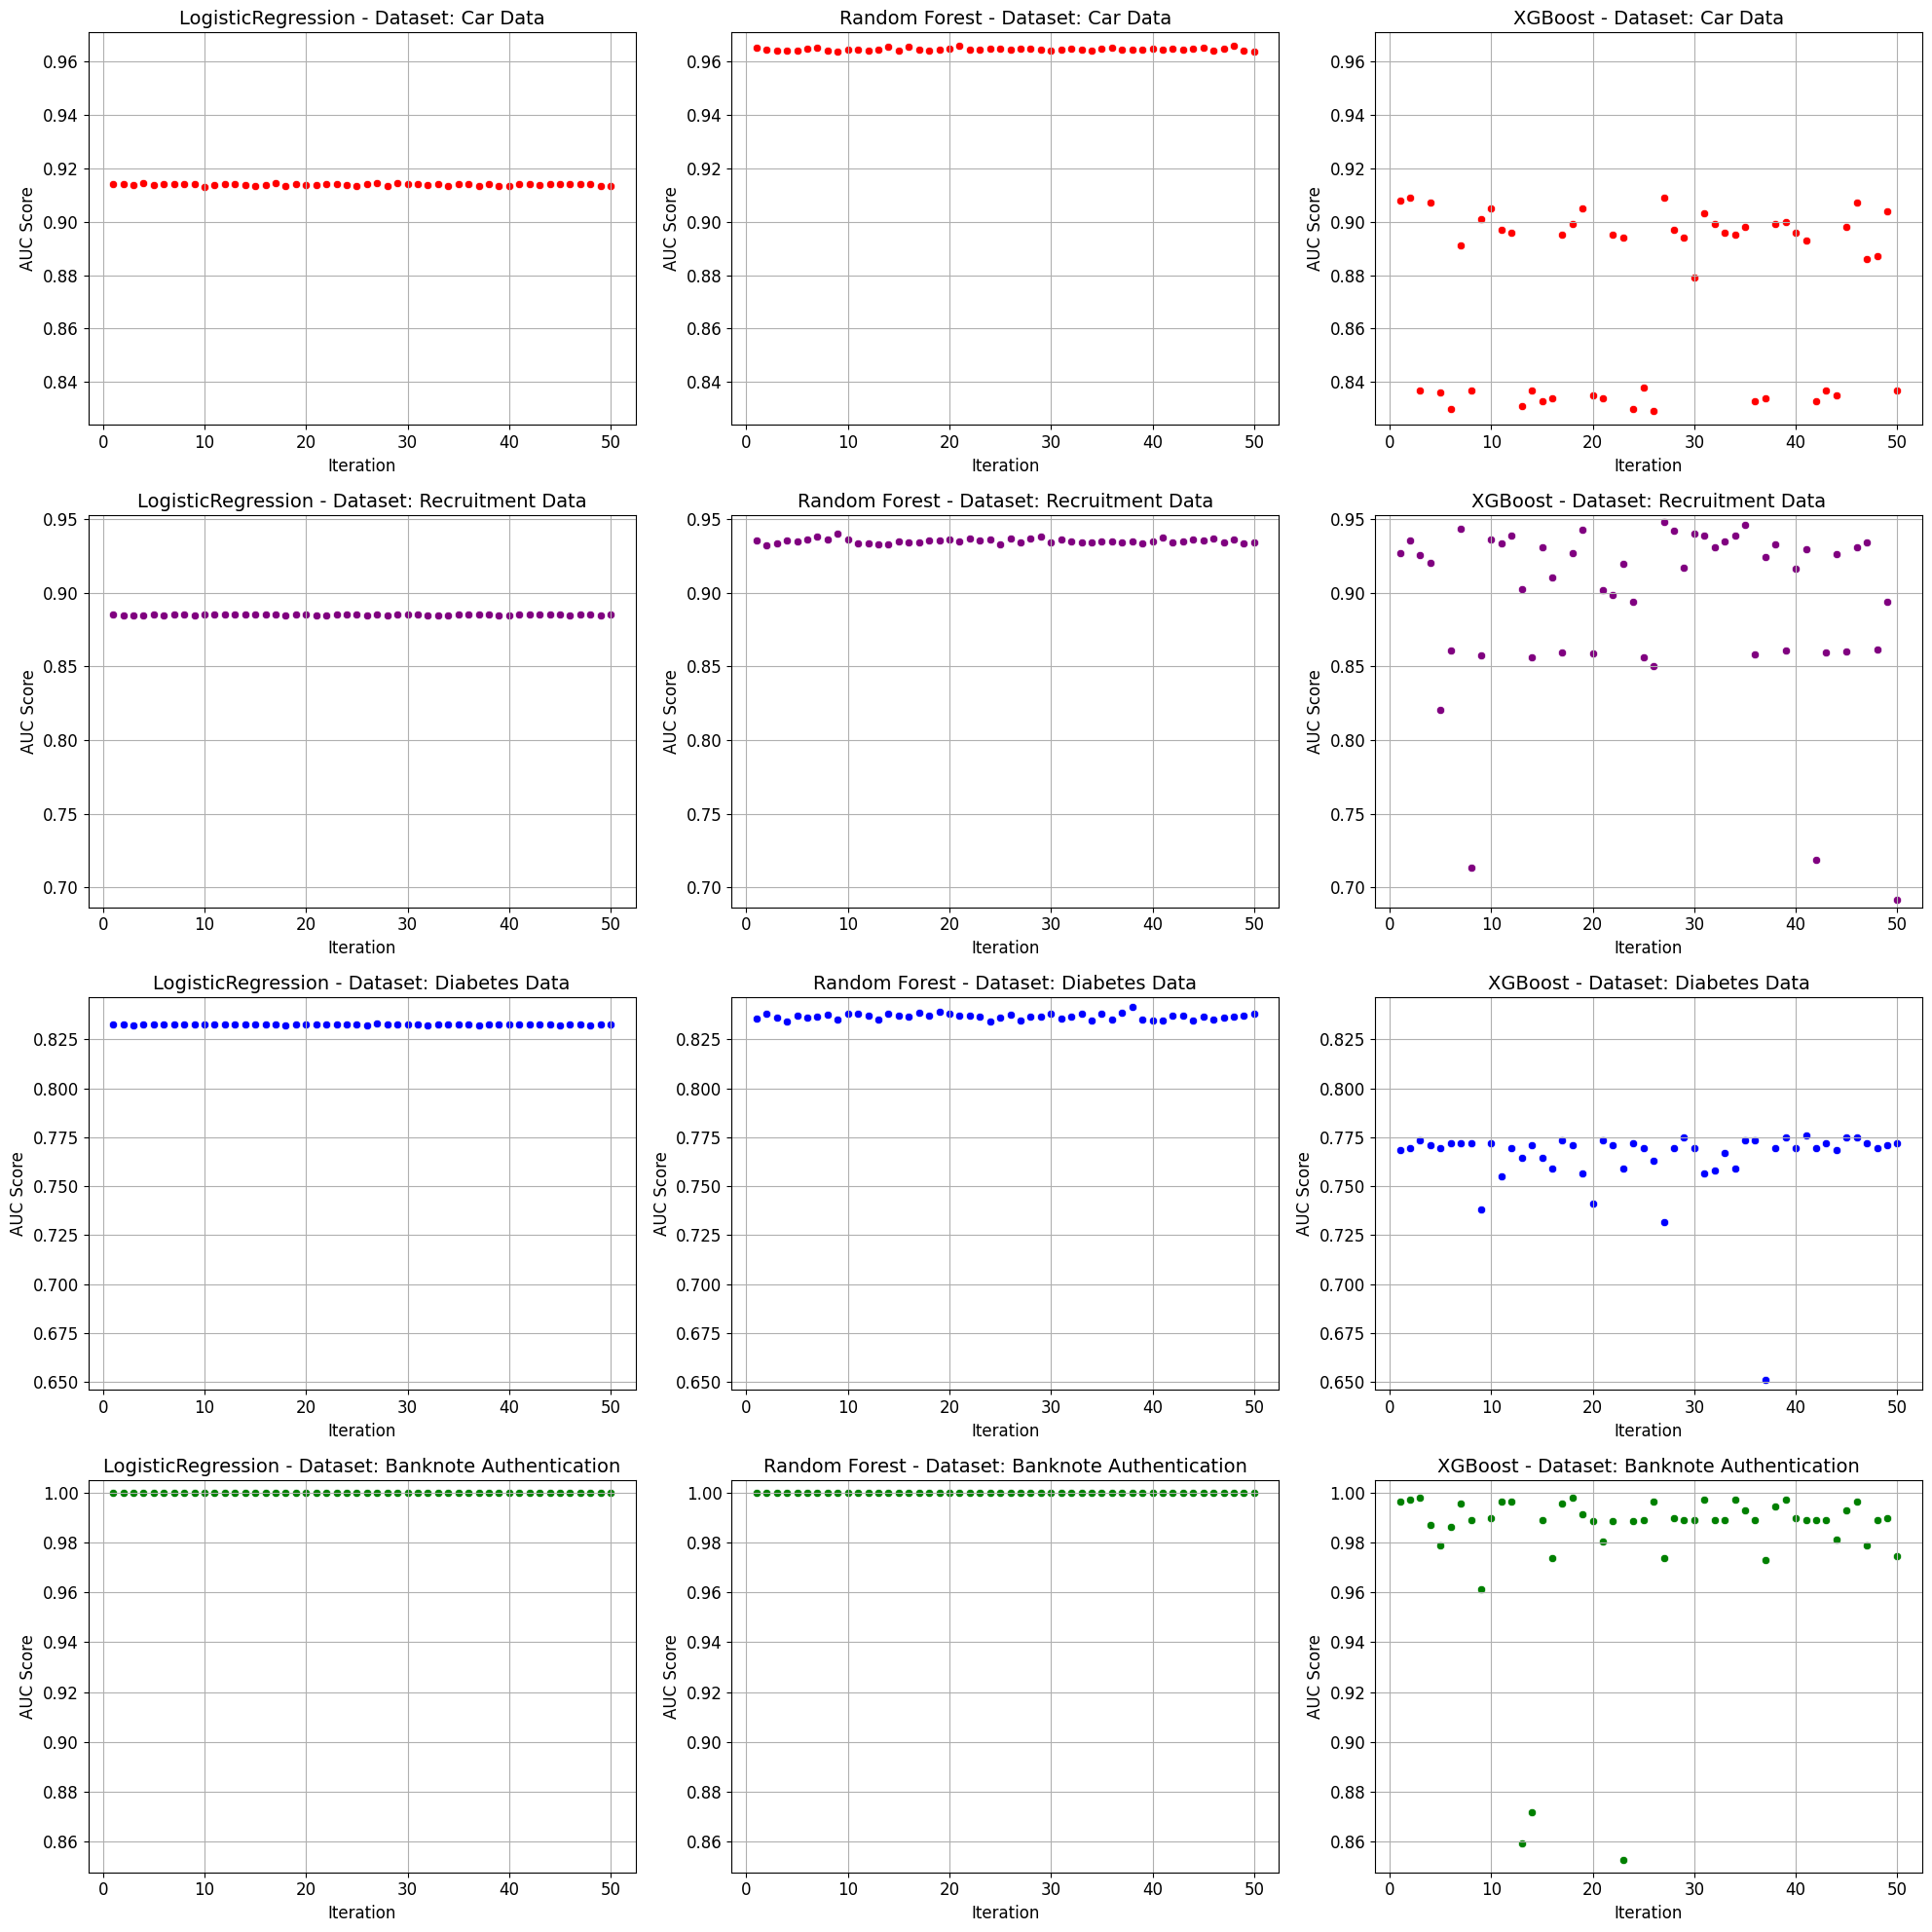

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Przygotowujemy listę nazw modeli
model_names = ["LogisticRegression", "Random Forest", "XGBoost"]

# Ustawienia dla większych podpisów
plt.rcParams.update({'font.size': 12})

# Tworzymy subploty: 4 wiersze (dla zbiorów danych) i 3 kolumny (dla modeli)
fig, axes = plt.subplots(4, 3, figsize=(20, 20))  # 4 wiersze, 3 kolumny

# Definiujemy kolory dla każdego wiersza
row_colors = ["red", "purple", "blue", "green"]

# Iteracja przez każdy zbiór danych (4 wiersze)
for i in range(4):
    # Wczytujemy dane dla `results_bayes` z plików CSV
    df_data = [
        pd.read_csv(f'/content/drive/MyDrive/AutoML-Projekt1/Results/{model_name}/results_bayes_{i}.csv')
        for model_name in ["LogisticRegression", "RANDOMFOREST", "XGBOOST"]
    ]

    # Znajdź minimalny i maksymalny Score dla każdego wiersza, aby ustawić wspólną skalę osi Y w danym wierszu
    min_score = min(df['Score'].min() for df in df_data)
    max_score = max(df['Score'].max() for df in df_data)

    # Iteracja przez każdy model (3 kolumny)
    for j in range(3):
        # Wykres punktowy AUC Score z linią pomocniczą dla iteracji, z odpowiednim kolorem dla wiersza
        sns.scatterplot(
            x=np.linspace(1, 50, 50), y=df_data[j]['Score'], marker='o', color=row_colors[i], ax=axes[i, j]
        )

        # Ustawiamy tytuł, opisy osi oraz zakres osi Y
        axes[i, j].set_title(f"{model_names[j]} - Dataset: {dataset_names[i]}", fontsize=14)
        axes[i, j].set_xlabel("Iteration", fontsize=12)
        axes[i, j].set_ylabel("AUC Score", fontsize=12)

        # Ustawienie tej samej skali Y dla wszystkich wykresów w danym wierszu
        axes[i, j].set_ylim(min_score - 0.005, max_score + 0.005)

        # Włączamy siatkę dla lepszej widoczności
        axes[i, j].grid(True)

# Dostosowujemy odstępy między wykresami
plt.tight_layout()

# Wyświetlamy i zapisujemy wykresy jako jeden plik PNG
plt.show()
fig.savefig('/content/drive/MyDrive/AutoML-Projekt1/Results/bayes_search_all_models_all_datasets_colors.png')
